<a href="https://colab.research.google.com/github/KilledByBugs/CE888_labs/blob/main/project1Ass2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
#dataset are saved to google drive, now mount the google drive
from google.colab import drive
from google.colab import files
import pandas as pd

drive.mount('/content/drive') #/content/drive/My Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!mkdir -p drive
!ls

drive  sample_data


In [3]:
os.chdir("/content/drive/My Drive/machineLearning/CE888")
!ls

Test  Training


In [4]:
class_names = ['Fire', 'No_Fire']
classes_number = 2 
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
IMAGE_SIZE = (254, 254)


In [7]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.mixed_precision import experimental as mixed_precision

policy = mixed_precision.Policy('mixed_float16') #using this policy to prevent too much usage of ram
mixed_precision.set_policy(policy)

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


**1. Load the data**

In [5]:
def load_data():
    """
        Load the data:
            - 39,375 frames to train the network.
            - another 8,617 frames are labeled for the test data
    """
    
    datasets = ['/content/drive/My Drive/machineLearning/CE888/Training', '/content/drive/My Drive/machineLearning/CE888/Test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("...Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                # Resize is not needed. the original images are in same size
                #image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float16') #using float16, int16 to prevent 
        labels = np.array(labels, dtype = 'int16')  #too much usage of ram 
        
        output.append((images, labels))

    return output

In [6]:
(train_images, train_labels), (test_images, test_labels) = load_data()

...Loading /content/drive/My Drive/machineLearning/CE888/Training


100%|██████████| 5292/5292 [00:22<00:00, 235.43it/s]


...Loading /content/drive/My Drive/machineLearning/CE888/Test


100%|██████████| 5137/5137 [00:22<00:00, 227.70it/s]


**2. Explore the dataset**

In [8]:
no_train = train_labels.shape[0]
no_test = test_labels.shape[0]

print ("Number of training examples: {}".format(no_train))
print ("Number of testing examples: {}".format(no_test))
print ("Image size of each image: {}".format(IMAGE_SIZE))

Number of training examples: 20835
Number of testing examples: 8617
Image size of each image: (254, 254)


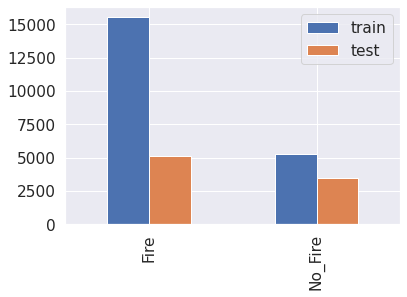

In [9]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,'test': test_counts}, index=class_names).plot.bar()
plt.show()

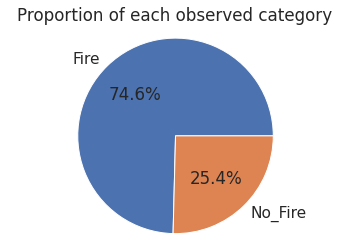

In [10]:
plt.pie(train_counts,
        explode=(0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [11]:
#scale the data
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [12]:
#display the 25 images from the training set

def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    image = []
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        image = images[i].astype(np.float32)
        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

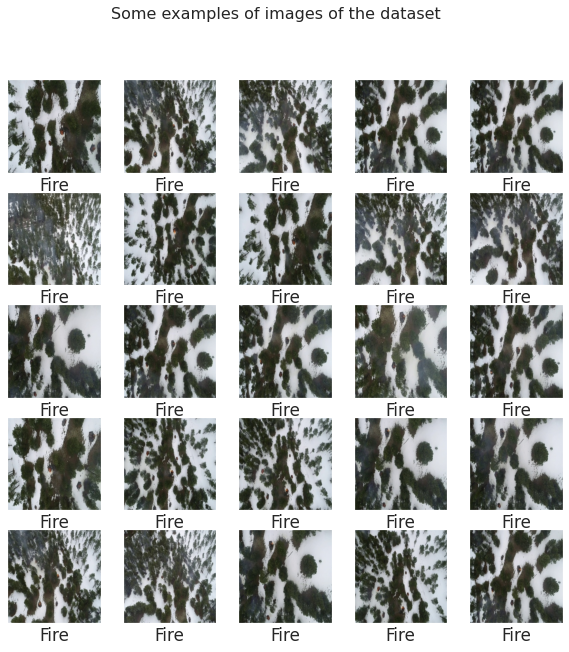

In [15]:
display_examples(class_names, train_images, train_labels)


**3. Training the model**

Build Simple Model

Build an easy model composed of different layers such as:

Conv2D: (32 filters of size 3 by 3) The features will be "extracted" from the image.

MaxPooling2D: The images get half sized.

Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.

Relu : given a value x, returns max(x, 0).

Softmax: 6 neurons, probability that the image belongs to one of the classes.

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (254, 254, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [14]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])


  opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt)



Fit the model to the data from the training set. The neural network will learn by itself the pattern in order to distinguish each category.

In [ ]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)


Epoch 1/20
 54/131 [===========>..................] - ETA: 2:03:51 - loss: 0.6068 - accuracy: 0.8799

In [ ]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['acc'],'bo--', label = "acc")
    plt.plot(history.history['val_acc'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

In [ ]:
plot_accuracy_loss(history)
